In [1]:
from copy import deepcopy
from math import log10
import sys
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.axes import Axes
from dotenv import load_dotenv

sys.path.append("../")

from core.components.parameters import Parameters  # noqa: E402
from core.components.utils import Utils  # noqa: E402
from core.model.subgraph_entry import SubgraphEntry  # noqa: E402
from core.model.topology_entry import TopologyEntry  # noqa: E402
from core.model.economic_model import EconomicModel  # noqa: E402
from core.model.peer import Peer  # noqa: E402
from core.node import Node  # noqa: E402


In [2]:
# Load environment variables
load_dotenv(".envs/apr_simulation.env")

params = Parameters()("SUBGRAPH_", "GCP_", "ECONOMIC_MODEL_")
nodes = Node.fromAddressListAndKey(*Utils.nodesAddresses("NODE_ADDRESS_", "NODE_KEY"))

api = nodes[-1].api
network_nodes = nodes[:-1]


### Get safe balances from subgraph and channel balances from the topology api endpoint 

In [3]:
async def get_subgraph_data():
    data = {
        "query": params.subgraph.query,
        "variables": {"first": params.subgraph.pagination_size, "skip": 0},
    }

    safes = []
    while True:
        _, response = await Utils.httpPOST(
            params.subgraph.url, data
        )

        if "data" not in response:
            break

        safes.extend(response["data"]["safes"])

        if len(response["data"]["safes"]) >= params.subgraph.pagination_size:
            data["variables"]["skip"] += params.subgraph.pagination_size
        else:
            break

    results = list[SubgraphEntry]()
    for safe in safes:
        results.extend(
            [
                SubgraphEntry.fromSubgraphResult(node)
                for node in safe["registeredNodesInNetworkRegistry"]
            ]
        )


    return results

async def get_topology_data():
    channels = await api.all_channels(False)

    results = await Utils.aggregatePeerBalanceInChannels(channels.all)
    return [TopologyEntry.fromDict(*arg) for arg in results.items()]

async def get_node_data():
    results = set[Peer]()

    for node in network_nodes:
        await node._retrieve_address()
        node_result = await node.api.peers(params=["peer_id", "peer_address"], quality=0.5)
        
        peers = {Peer(item["peer_id"], item["peer_address"]) for item in node_result}
        results.update(peers)

    return results

In [4]:
topology = await get_topology_data()
print(f"Topology size: {len(topology)}")

subgraph = await get_subgraph_data()
print(f"Subgraph size: {len(subgraph)}")

peers = await get_node_data()
print(f"Number of peers: {len(peers)}")


Topology size: 387
Subgraph size: 543
Number of peers: 357


In [5]:
eligible = Utils.mergeTopologyPeersSubgraph(topology, peers, subgraph)
Utils.allowManyNodePerSafe(eligible)
Utils.excludeElements(eligible, [node.address for node in network_nodes])
model = EconomicModel.fromGCPFile(
    params.gcp.bucket, params.economic_model.filename
)
for peer in eligible:
    peer.economic_model = model
    
Utils.rewardProbability(eligible)

print(f"Eligible peers: {len(eligible)}")

Eligible peers: 275


In [15]:
def stake_transformation(values, slope, curvature, threshold):
    transformed_stakes = []

    for x in values:
        if x <= 10e3:
            transformed_stakes.append(1e-20)
        elif x <= threshold:
            f_x = slope * x
            transformed_stakes.append(f_x)
        else:
            g_x = slope * threshold  + (x - threshold) ** (1 / curvature)
            transformed_stakes.append(g_x)

    return transformed_stakes

def compute_probabilities(stakes: list):
    sum_stakes = sum(stakes)
    return [s / sum_stakes for s in stakes]

def compute_rewards(probabilities: list, budget: int):
    return [p * budget for p in probabilities]

def compute_apr(opt: dict, data: list, percentage: bool = False, average: bool= True, on_stake: bool = False):
    transformed_stakes = stake_transformation(data, **opt["model_arguments"])

    probabilities = compute_probabilities(transformed_stakes)

    rewards = compute_rewards(probabilities, opt["budget"])

    if percentage:
        factor = 100
    else:
        factor = 1

    period_apr = [r / s for r, s in zip(rewards, data if on_stake else transformed_stakes)]
    yearly_apr = [apr * 12 / opt["period_in_months"] * factor for apr in period_apr]

    apr = sum(yearly_apr) / len(yearly_apr) if average else yearly_apr

    return apr

def factor_and_prefix(value):
    factor = int(int(log10(value))/3)*3
    if factor < 3:
        prefix = ""
    elif factor < 6:
        prefix = "k"
    elif factor < 9:
        prefix = "M"

    return 10**factor, prefix

def compute_aprs(data: list, options: list[dict]):
    aprs = []

    for idx, opt in enumerate(options):
        tf_stakes = stake_transformation(data, **opt["model_arguments"])
        aprs.append(compute_apr(opt, tf_stakes, percentage=False))

    return aprs

def generate_simulation_graph(data:list, options: list[dict], title: str = None, cols:int=3):
    rows = int(len(options) / cols + 0.5)
    if rows * cols < len(options):
        rows += 1

    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(cols*6,rows*6), dpi=300)

    axes = [axes] if isinstance(axes, Axes) else axes.flatten()


    aprs = compute_aprs(data, options)
    

    for opt, apr, ax in zip(options, aprs, axes):
        max_stakes = max(data)
        stakes = np.linspace(0, max_stakes, 1000)
        factor, prefix = factor_and_prefix(stakes[-1])

        tf_stakes = stake_transformation(stakes, **opt["model_arguments"])


        tf_data_points = stake_transformation(data, **opt["model_arguments"])

        stakes_for_plt = [s/factor for s in stakes]
        tf_stakes_for_plt = [s/factor for s in tf_stakes]

        data_points_for_plt = [s/factor for s in data]
        tf_data_points_for_plt = [s/factor for s in tf_data_points]

        messages_per_second = opt["budget"] / (opt["ticket_options"]["price"] * opt["ticket_options"]["winning_probability"]) / (opt["period_in_months"] * 30 * 24 * 60 * 60)


        ax.plot(stakes_for_plt, tf_stakes_for_plt, label=opt["legend"])
        ax.scatter(data_points_for_plt, tf_data_points_for_plt, s=12, alpha=0.8, c="#ff7f0e")

        ax.set_xlabel(f"Stake (/{prefix}/HOPR)")
        ax.set_ylabel(f"Transformed stake (/{prefix}/HOPR)")
        ax.text(0.1,
                0.8,
                f"APR: {apr:.2%}",
                transform=ax.transAxes,
                horizontalalignment='left',
                bbox=dict(facecolor='red', alpha=0.5),)
        ax.text(0.1,
                0.7,
                f"Messages/s: {messages_per_second:.2f}",
                transform=ax.transAxes,
                horizontalalignment='left',
                bbox=dict(facecolor='blue', alpha=0.5),)

        # set the x and y scale equal
        ax.set_aspect('equal', adjustable='box')
        ax.set_ylim(ax.get_xlim())

        ax.legend()
        ax.grid()

    # remove unused axes
    for ax in axes[len(options):]:
        ax.remove()

    if title:
        if len(options) == 1:
            plt.title(title, fontsize=10)
        else:
            fig.suptitle(title, fontsize=20)
    plt.subplots_adjust(top=0.9)
    plt.show()

In [16]:
data = [entry.split_stake for entry in eligible] 

# aim for 15% APR
prefered = {
    "budget": model.budget.budget,
    "period_in_months": model.budget.period / (60*60*24*30),
    "model_arguments": {
        "slope": model.parameters.a,
        "curvature": model.parameters.b,
        "threshold": model.parameters.c
    },
    "ticket_options": {
        "price": model.budget.ticket_price,
        "winning_probability": model.budget.winning_probability,
    },
    "legend": "",
}


### Economic model

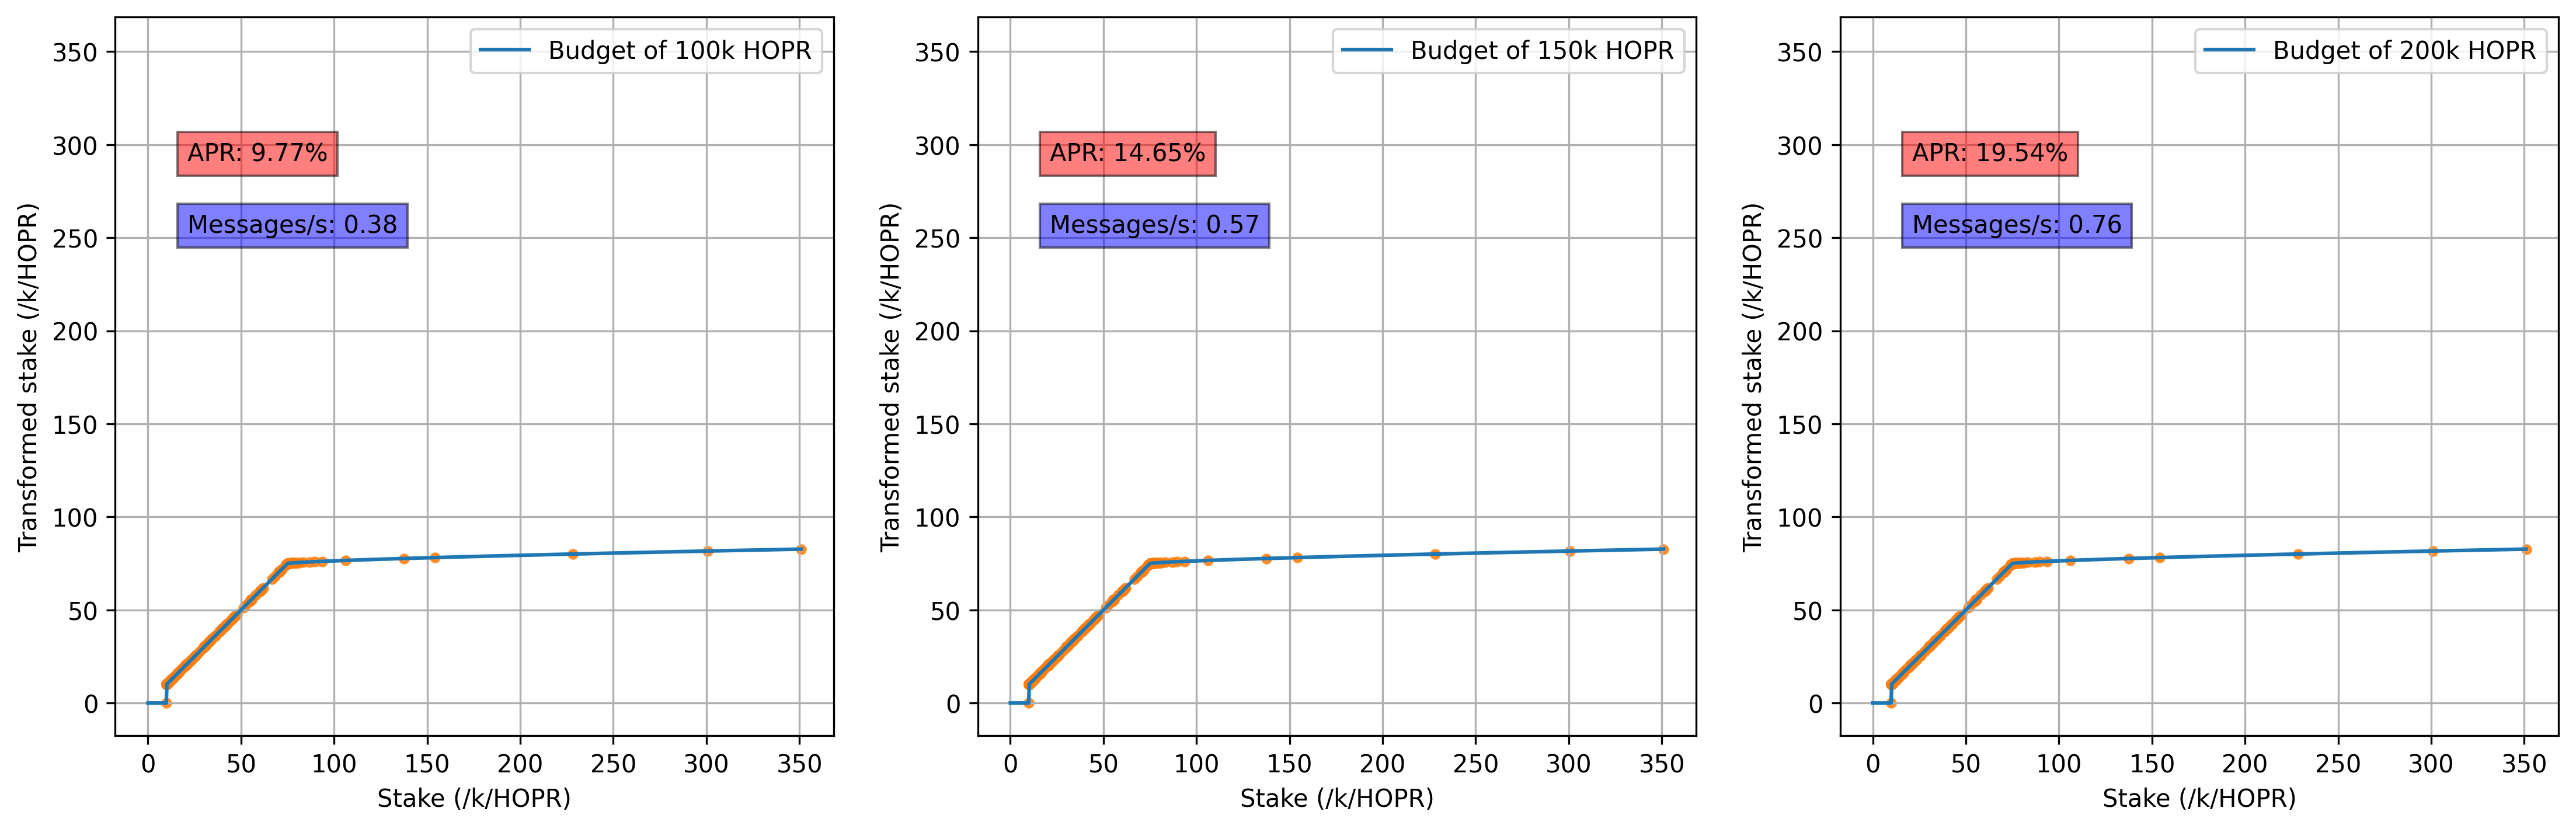

In [25]:
prefered_vars = [deepcopy(prefered) for _ in range(3)]

prefered_vars[1]["budget"] = 150_000
prefered_vars[2]["budget"] = 200_000


for opt in prefered_vars:
    opt["legend"] = f"Budget of {opt['budget'] / 1e3:.0f}k HOPR"

generate_simulation_graph(data, prefered_vars)

In [9]:
print(f"min stake: {min(data):.2f} HOPR")
print(f"max stake: {max(data):.2f} HOPR")
print(f"average stake: {np.mean(data):.2f} HOPR")
print(f"median stake: {np.median(data):.2f} HOPR")

min stake: 10000.00 HOPR
max stake: 351004.55 HOPR
average stake: 47698.08 HOPR
median stake: 42039.64 HOPR


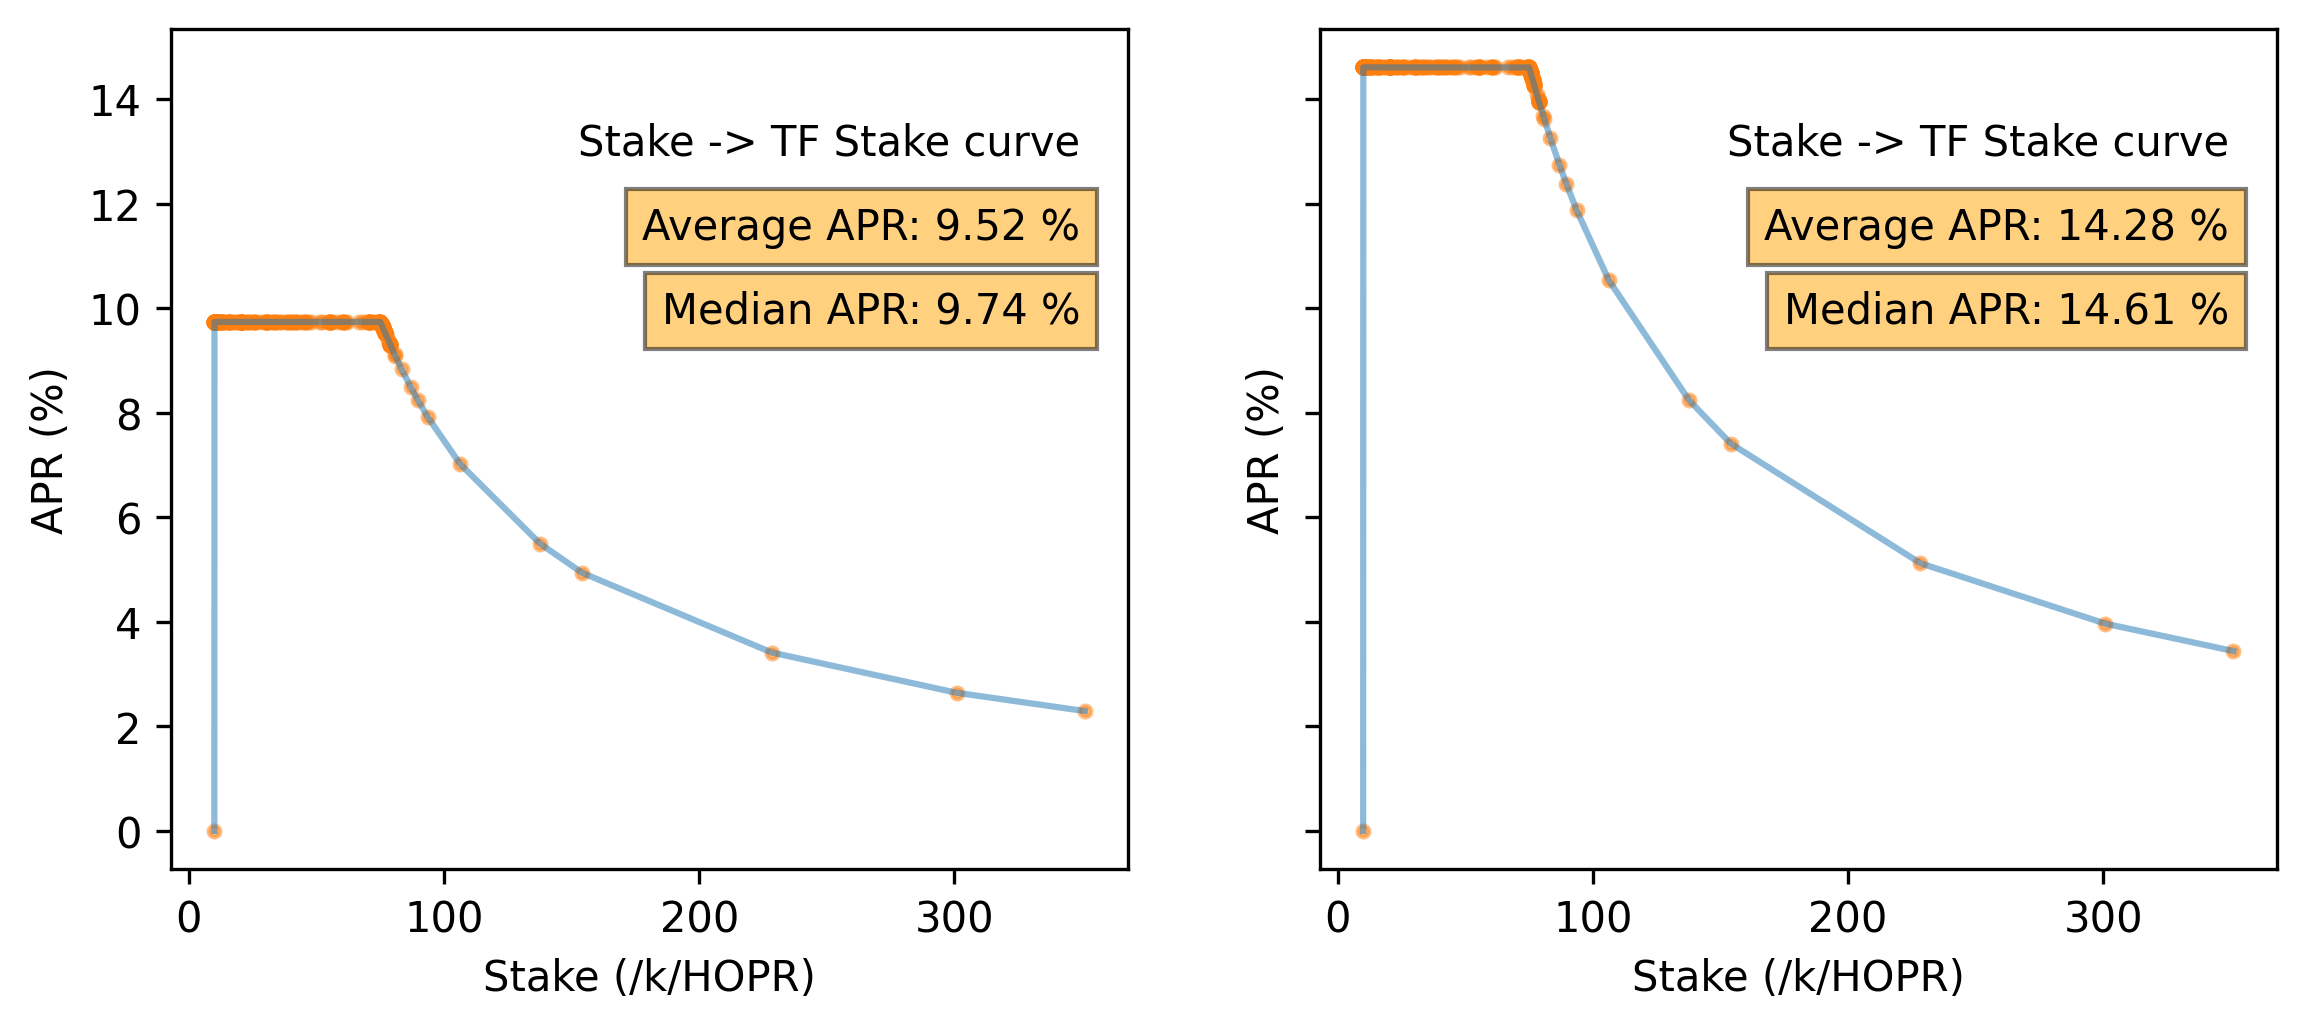

In [22]:
_, axes = plt.subplots(2, 3, figsize=(14, 8), dpi=300, sharey=True)
axes = axes.flatten()
options = deepcopy(prefered_vars)

for opt, ax in zip(options, axes):
    stakes = sorted(data)

    lin_range = np.linspace(0, max(stakes), 1000)

    aprs = compute_apr(opt, stakes, percentage=True, average=False, on_stake=True)

    average_apr = np.mean(aprs)
    median_apr = np.median(aprs)

    factor, prefix = factor_and_prefix(stakes[-1])

    stakes = [s/factor for s in stakes]

    ax.plot(stakes, aprs, alpha=0.5)
    ax.scatter(stakes, aprs, s=8, c="#ff7f0e", alpha=0.5)
    ax.text(0.95,
            0.85,
            opt["legend"],
            transform=ax.transAxes,
            horizontalalignment='right')
    ax.text(0.95,
            0.75,
            f"Average APR: {average_apr:,.2f} %",
            transform=ax.transAxes,
            horizontalalignment='right',
            bbox=dict(facecolor='orange', alpha=0.5),)
    ax.text(0.95,
        0.65,
        f"Median APR: {median_apr:,.2f} %",
        transform=ax.transAxes,
        horizontalalignment='right',
        bbox=dict(facecolor='orange', alpha=0.5),)

    ax.set_xlabel(f"Stake (/{prefix}/HOPR)")
    ax.set_ylabel("APR (%)")

# remove unused subplots
for ax in axes[len(options):]:
    ax.remove()

plt.show()